# Installations

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q evaluate

# Load Datasets

In [3]:
from datasets import load_dataset

dataset = load_dataset("miladfa7/5-Flower-Types-Classification-Dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4999
    })
})

In [5]:
# input labels
id2label = {
  0: "Lilly",
  1: "Lotus",
  2: "Orchid",
  3: "Sunflower",
  4: "Tulip"
}

id2color = {
    0: "red",
    1: "blue",
    2: "green",
    3: "black",
    4: "pink"
}

label2id = {
  "Lilly": 0,
  "Lotus": 1,
  "Orchid": 2,
  "Sunflower": 3,
  "Tulip": 4
}

# Preprocessing

In [6]:
# import the necessary packages
import cv2
import numpy as np

class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect
		# ratio

		image = cv2.resize(image, (self.width, self.height),
                              interpolation=self.inter)

		return image

# Data Loader

In [7]:
# import the necessary packages
import numpy as np
import cv2
import os

class SimpleDatasetLoader:
  def __init__(self, preprocessors=None):
    # store the image preprocessor
    self.preprocessors = preprocessors
    # if the preprocessors are None, initialize them as an
    # empty list
    if self.preprocessors is None:
      self.preprocessors = []

  def load_path(self, imagePaths, verbose=-1):
    # initialize the list of features and labels
    data = []
    labels = []

    # loop over the input images
    for (i, imagePath) in enumerate(imagePaths):
      # load the image and extract the class label assuming
      # that our path has the following format:
      # /path/to/dataset/{class}/{image}.jpg
      image = cv2.imread(imagePath)
      label = imagePath.split(os.path.sep)[-1][0:2]

      # check to see if our preprocessors are not None
      if self.preprocessors is not None:
        # loop over the preprocessors and apply each to
        # the image
        for p in self.preprocessors:
          image = p.preprocess(image)
      # treat our processed image as a "feature vector"
      # by updating the data list followed by the labels
      data.append(image)
      labels.append(label)
      # show an update every `verbose` images
      if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
        print("[INFO] processed {}/{}".format(i + 1, len(imagePaths)))

    # return a tuple of the data and labels
    return (np.array(data), np.array(labels))

  def load_dataset(self, dataset, id2label, verbose=-1):
    # initialize the list of features and labels
    data = []
    labels = []

    # loop over the input images
    for (i, img) in enumerate(dataset):
      image = np.array(img["image"])
      label = id2label[img["label"]]

      # check to see if our preprocessors are not None
      if self.preprocessors is not None:
        # loop over the preprocessors and apply each to
        # the image
        for p in self.preprocessors:
          image = p.preprocess(image)
      # treat our processed image as a "feature vector"
      # by updating the data list followed by the labels
      data.append(image)
      labels.append(label)
      # show an update every `verbose` images
      if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
        print("[INFO] processed {}/{}".format(i + 1, len(dataset)))

    # return a tuple of the data and labels
    return (np.array(data), np.array(labels))


# Raw KNN

In [8]:
# import the necessary packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import argparse

In [9]:
# construct the argument parse and parse the arguments
args_dataset = "/content/drive/MyDrive/colab_data/dataset_flower/flowers/flowers"
args_jobs = -1
args_neighbors = 1

args = {
    "dataset": args_dataset,
    "jobs": args_jobs,
    "neighbors": args_neighbors
}

In [10]:
# grab the list of images that we'll be describing
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))

# initialize the image preprocessor, load the dataset from disk,
# and reshape the data matrix
image_resize_h = 32
image_resize_w = 32
dimension = 3 # 3 like rgb (tuple), 1 for gray map

sp = SimplePreprocessor(image_resize_h, image_resize_w)
sdl = SimpleDatasetLoader(preprocessors=[sp])

# (data, labels) = sdl.load_path(imagePaths, verbose=50)
(data, labels) = sdl.load_dataset(dataset["train"], id2label, verbose=500)

data = data.reshape((data.shape[0],
                     image_resize_h * image_resize_w * dimension))

# show some information on memory consumption of the images
print("[INFO] features matrix: {:.1f}MB".format(
	data.nbytes / (1024 * 1024.0)))

# encode the labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

print(labels)
print(le.classes_)

[INFO] loading images...
[INFO] processed 500/4999
[INFO] processed 1000/4999
[INFO] processed 1500/4999
[INFO] processed 2000/4999
[INFO] processed 2500/4999
[INFO] processed 3000/4999
[INFO] processed 3500/4999
[INFO] processed 4000/4999
[INFO] processed 4500/4999
[INFO] features matrix: 14.6MB
[0 0 0 ... 4 4 4]
['Lilly' 'Lotus' 'Orchid' 'Sunflower' 'Tulip']


In [11]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.25,
                                                  random_state=42)

In [12]:
# train and evaluate a k-NN classifier on the raw pixel intensities
print("[INFO] evaluating k-NN classifier...")

model = KNeighborsClassifier(n_neighbors=args["neighbors"],
                             n_jobs=args["jobs"])
model.fit(trainX, trainY)

print(classification_report(testY, model.predict(testX), target_names=le.classes_))

[INFO] evaluating k-NN classifier...
              precision    recall  f1-score   support

       Lilly       0.75      0.65      0.70       264
       Lotus       0.66      0.79      0.72       248
      Orchid       0.71      0.72      0.71       246
   Sunflower       0.88      0.77      0.82       246
       Tulip       0.68      0.71      0.69       246

    accuracy                           0.73      1250
   macro avg       0.73      0.73      0.73      1250
weighted avg       0.73      0.73      0.73      1250



# Dino V2

## Prediction without training

In [20]:
from transformers import Dinov2Model
from transformers import AutoImageProcessor, AutoModel, Dinov2ForImageClassification
import torch

# model = Dinov2Model.from_pretrained("facebook/dinov2-base", id2label=id2label, num_labels=len(id2label))

# image_processor = AutoImageProcessor.from_pretrained("timm/vit_large_patch14_dinov2.lvd142m", id2label=id2label, num_labels=len(id2label))
# model = Dinov2ForImageClassification.from_pretrained("timm/vit_large_patch14_dinov2.lvd142m", id2label=id2label, num_labels=len(id2label))
# dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

image_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model_classification = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-base", id2label=id2label)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model = model.to(device)

Device:  cpu


In [16]:
sp = SimplePreprocessor(image_resize_h, image_resize_w)
sdl = SimpleDatasetLoader(preprocessors=[sp])

(data, labels) = sdl.load_dataset(dataset["train"], id2label, verbose=500)

[INFO] processed 500/4999
[INFO] processed 1000/4999
[INFO] processed 1500/4999
[INFO] processed 2000/4999
[INFO] processed 2500/4999
[INFO] processed 3000/4999
[INFO] processed 3500/4999
[INFO] processed 4000/4999
[INFO] processed 4500/4999


In [17]:
import numpy as np
import random

data_tensor = []
label_predicted = []
label_pretrained = []

verbose = 500

n_max = 20

for i in range(n_max):
  image_id = random.randint(0, len(data))
  label_pretrained.append(labels[image_id])
  image = data[image_id]

  inputs = image_processor(image, return_tensors="pt")

  with torch.no_grad():
    outputs = model(**inputs).last_hidden_state.reshape(1, -1).tolist()
    logits = model_classification(**inputs).logits
    data_tensor.append(outputs)
    label_predicted.append(logits.argmax(-1).item())

  print("[INFO] processed {}/{}".format(image_id, dataset["train"].num_rows))

[INFO] processed 2915/4999
[INFO] processed 2457/4999
[INFO] processed 4227/4999
[INFO] processed 2369/4999
[INFO] processed 839/4999
[INFO] processed 4998/4999
[INFO] processed 4453/4999
[INFO] processed 886/4999
[INFO] processed 3912/4999
[INFO] processed 3464/4999
[INFO] processed 4432/4999
[INFO] processed 772/4999
[INFO] processed 4382/4999
[INFO] processed 3216/4999
[INFO] processed 1444/4999
[INFO] processed 1005/4999
[INFO] processed 258/4999
[INFO] processed 3199/4999
[INFO] processed 4583/4999
[INFO] processed 2939/4999


In [18]:
# print(data_tensor)
print(label_predicted)
print(label_pretrained)

results = [label_predicted[i] == label2id[label_pretrained[i]] for i in range(len(label_pretrained))]

def compute_accuracy(tab):
  somme = 0
  for i in results:
    if i is True:
      somme += 1
  return somme/len(results)

print(compute_accuracy(results))
print([label_predicted[i] == label2id[label_pretrained[i]] for i in range(len(label_pretrained))])

[1, 2, 4, 4, 0, 2, 4, 1, 0, 2, 4, 1, 3, 2, 1, 1, 2, 4, 0, 2]
['Orchid', 'Orchid', 'Tulip', 'Orchid', 'Lilly', 'Tulip', 'Tulip', 'Lilly', 'Sunflower', 'Sunflower', 'Tulip', 'Lilly', 'Tulip', 'Sunflower', 'Lotus', 'Lotus', 'Lilly', 'Sunflower', 'Tulip', 'Orchid']
0.4
[False, True, True, False, True, False, True, False, False, False, True, False, False, False, True, True, False, False, False, True]


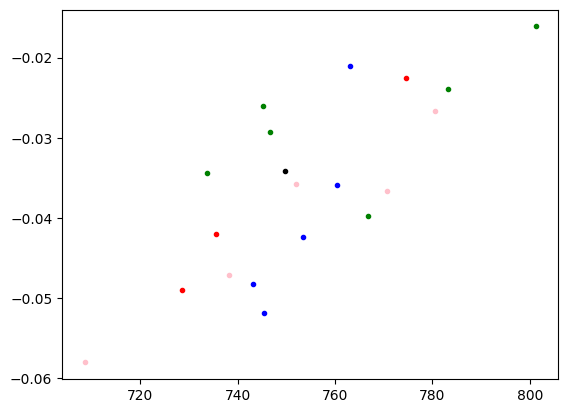

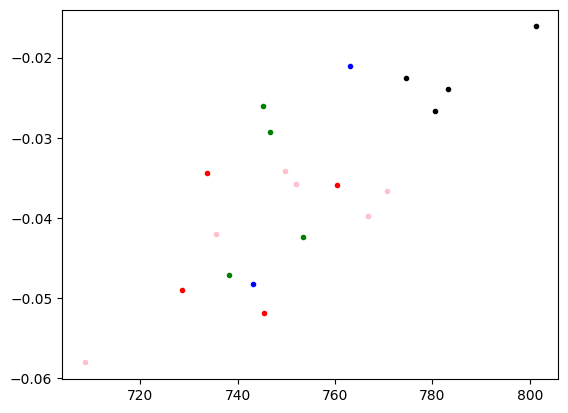

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np

for i in range(len(data_tensor)):
  plt.plot(np.linalg.norm(data_tensor[i]), np.mean(data_tensor[i]), '.', color=id2color[label_predicted[i]]) # easy and simple
  #plt.plot(data_tensor[i][0][1], data_tensor[i][0][2], '.', color=id2color[label_predicted[i]]) # easy and simple

plt.show()

plt.figure()

for i in range(len(data_tensor)):
  plt.plot(np.linalg.norm(data_tensor[i]), np.mean(data_tensor[i]), '.', color=id2color[label2id[label_pretrained[i]]]) # easy and simple
  #plt.plot(data_tensor[i][0][1], data_tensor[i][0][2], '.', color=id2color[label2id[label_pretrained[i]]])

plt.show()

## Training a Model

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

In [ ]:
def preprocess_dataset(dataset, transform):
    # loop over the input images
    for (i, img) in enumerate(dataset):
      img["image"] = transform(img["image"])

      img["image"] = np.array(img["image"])
    return dataset


# Define a function for loading and transforming image data
def load_classification_data(data_dir='data/classification/train'):
    # Define transformations: random crop, random flip, convert to tensor, and normalize
    transform = transforms.Compose([
        transforms.RandomResizedCrop(32),  # Resize and crop the image to a 224x224 square
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image with mean and standard deviation
    ])

    # Load the dataset from directory and apply transformations
    full_dataset = datasets.ImageFolder(data_dir, transform)
    # full_dataset = load_dataset("miladfa7/5-Flower-Types-Classification-Dataset")
    # full_dataset = preprocess_dataset(full_dataset["train"], transform)

    # Split the full dataset into train and validation sets
    train_size = int(0.8 * len(full_dataset))  # 80% of the dataset is used for training
    val_size = len(full_dataset) - train_size  # The rest is used for validation

    # Randomly split dataset into training and validation dataset
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create data loaders for train and validation sets
    # They provide an easy way to iterate over the dataset in mini-batches
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle the training data
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # No need to shuffle validation data

    return {'train': train_loader, 'val': val_loader}  # Return loaders and number of classes in the dataset

In [ ]:
def train_classification_model(model, dataloaders, criterion, optimizer, scheduler, device, n_epochs_stop=6):
    # Initialize variables
    min_val_loss = np.Inf  # Minimum validation loss starts at infinity
    epochs_no_improve = 0  # No improvement in epochs counter

    # Loop over epochs
    for epoch in range(100):
        print('Epoch {}/{}'.format(epoch, 100 - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            # Initialize metrics for this phase
            running_loss = 0.0  # Accumulate losses over the epoch
            correct = 0  # Count correct predictions
            total = 0  # Count total predictions

            # Use tqdm for progress bar
            with tqdm(total=len(dataloaders[phase]), unit='batch') as p:
                # Iterate over mini-batches
                for inputs, labels in dataloaders[phase]:
                    # Move input and label tensors to the default device (GPU or CPU)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Clear the gradients of all optimized variables
                    optimizer.zero_grad()

                    # Forward pass: compute predicted outputs by passing inputs to the model
                    with torch.set_grad_enabled(phase == 'train'):  # Only calculate gradients in training phase
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)  # Get the class with the highest probability
                        loss = criterion(outputs, labels)  # Compute the loss

                        # Perform backward pass and optimization only in the training phase
                        if phase == 'train':
                            loss.backward()  # Calculate gradients based on the loss
                            optimizer.step()  # Update model parameters based on the current gradient

                    # Update running loss and correct prediction count
                    running_loss += loss.item() * inputs.size(0)  # Multiply average loss by batch size
                    total += labels.size(0)
                    correct += (preds == labels).sum().item()  # Update correct predictions count

                    # Update the progress bar
                    p.set_postfix({'loss': loss.item(), 'accuracy': 100 * correct / total})
                    p.update(1)

                # Calculate loss and accuracy for this epoch
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = 100 * correct / total

                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(phase, epoch_loss, epoch_acc))

                # Save model and implement early stopping in validation phase
                if phase == 'val':
                    if epoch_loss < min_val_loss:
                        print(f'Validation Loss Decreased({min_val_loss:.6f}--->{epoch_loss:.6f}) \t Saving The Model')
                        min_val_loss = epoch_loss  # Update minimum validation loss
                        torch.save(model.state_dict(), 'weights/classification_model.pt')  # Save the current model weights
                        epochs_no_improve = 0  # Reset epochs since last improvement
                    else:
                        epochs_no_improve += 1
                        # Implement early stopping
                        if epochs_no_improve == n_epochs_stop:
                            print('Early stopping!')
                            model.load_state_dict(torch.load('weights/classification_model.pt'))  # Load the best model weights
                            model.eval()
                            return model  # Exit the function early

            # Adjust the learning rate based on the scheduler
            scheduler.step(epoch_loss)

    # Return the trained model
    return model

In [ ]:
dataset_load  = load_classification_data(data_dir="/content/drive/MyDrive/colab_data/dataset_flower/flower_images")

In [ ]:
print(dataset_load)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7af0b2883c40>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7af0bf27ffa0>}


In [ ]:
print(dataset_load["train"])

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # put model on GPU (set runtime to GPU in Google Colab)
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# put model in training mode
# model.train()

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7, verbose=True)
# model = train_classification_model(model, dataset_load, criterion, optimizer, scheduler, device)

# KNN on DinoV2 vectors

In [13]:
from transformers import Dinov2Model
from transformers import AutoImageProcessor, AutoModel, Dinov2ForImageClassification
import torch

image_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model = model.to(device)

Device:  cpu


In [14]:
classe_id = {
    0: 0,
    1: 1000,
    2: 2000,
    3: 3000,
    4: 4000
}

In [15]:
sp = SimplePreprocessor(244, 244)
sdl = SimpleDatasetLoader(preprocessors=[sp])

(data, labels) = sdl.load_dataset(dataset["train"], id2label, verbose=500)

[INFO] processed 500/4999
[INFO] processed 1000/4999
[INFO] processed 1500/4999
[INFO] processed 2000/4999
[INFO] processed 2500/4999
[INFO] processed 3000/4999
[INFO] processed 3500/4999
[INFO] processed 4000/4999
[INFO] processed 4500/4999


## Ensemble de validation

In [117]:
import numpy as np
import random

number_validation_per_classes = 100

data_validation_tensor = np.zeros((len(id2label)*number_validation_per_classes, 197376))
label_validation_correct = np.zeros((number_validation_per_classes*len(id2label),))

for cid in classe_id.keys():
  for i in range(number_validation_per_classes):
    image_id = classe_id[cid] + i
    image = data[image_id]

    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
      logits = model(**inputs).last_hidden_state.reshape(1, -1).tolist()[0]
      id = int(cid)*number_validation_per_classes + i
      data_validation_tensor[id] = logits
      label_validation_correct[id] = cid

    print("[INFO] processed {}/{}".format(image_id, dataset["train"].num_rows))

[INFO] processed 0/4999
[INFO] processed 1/4999
[INFO] processed 2/4999
[INFO] processed 3/4999
[INFO] processed 4/4999
[INFO] processed 5/4999
[INFO] processed 6/4999
[INFO] processed 7/4999
[INFO] processed 8/4999
[INFO] processed 9/4999
[INFO] processed 10/4999
[INFO] processed 11/4999
[INFO] processed 12/4999
[INFO] processed 13/4999
[INFO] processed 14/4999
[INFO] processed 15/4999
[INFO] processed 16/4999
[INFO] processed 17/4999
[INFO] processed 18/4999
[INFO] processed 19/4999
[INFO] processed 20/4999
[INFO] processed 21/4999
[INFO] processed 22/4999
[INFO] processed 23/4999
[INFO] processed 24/4999
[INFO] processed 25/4999
[INFO] processed 26/4999
[INFO] processed 27/4999
[INFO] processed 28/4999
[INFO] processed 29/4999
[INFO] processed 30/4999
[INFO] processed 31/4999
[INFO] processed 32/4999
[INFO] processed 33/4999
[INFO] processed 34/4999
[INFO] processed 35/4999
[INFO] processed 36/4999
[INFO] processed 37/4999
[INFO] processed 38/4999
[INFO] processed 39/4999
[INFO] pro

In [118]:
## print(label_validation_correct)
print(len(data_validation_tensor), len(data_validation_tensor[0]))

500 197376


In [119]:
print(data_validation_tensor)
print(label_validation_correct)

[[ 0.85902995  1.79945254  0.22009277 ...  0.51550406 -2.51012492
  -1.83473766]
 [ 1.26890063 -2.51034212  0.09431291 ...  0.8599776  -0.66391855
  -1.04202712]
 [-0.104789    0.19976455 -0.56448293 ...  0.37749782 -0.70874113
   0.82947987]
 ...
 [ 1.70491064  0.74980694  0.00687525 ...  1.04908621  0.47470421
   1.00151646]
 [ 4.01766586  1.46384001 -0.95005727 ...  0.56969684 -2.74273038
  -2.32414222]
 [ 3.84879422  0.90132111  0.55567944 ...  2.30645633 -0.18652727
  -1.4061954 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

## Ensemble de test

In [ ]:
import numpy as np
import random

number_test_per_classes = 100
max_validation_samples = 100

data_test_tensor = np.zeros((number_test_per_classes*len(id2label), 197376))
label_test_correct = np.zeros((number_test_per_classes*len(id2label),))

for cid in classe_id.keys():
  for i in range(number_test_per_classes):
    # image_id = classe_id[cid] + random.randint(number_validation_per_classes+1, 999)
    image_id = classe_id[cid] + max_validation_samples + i

    image = data[image_id]

    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
      logits = model(**inputs).last_hidden_state.reshape(1, -1).tolist()[0]
      id = int(cid)*number_test_per_classes + i
      data_test_tensor[id] = logits
      label_test_correct[id] = cid

    print("[INFO] processed {}/{}".format(image_id, dataset["train"].num_rows))

In [83]:
print(len(data_test_tensor), len(data_test_tensor[0]))
# print(label_test_predicted)
# print(label_test_correct)

500 197376


In [82]:
print(data_test_tensor)
print(label_test_correct)

[[ 1.26774037 -2.17363548 -3.87501383 ... -2.06406641  0.73959845
   0.48893264]
 [ 0.41180208  1.52246845  1.5932132  ... -1.60640943 -0.66213024
  -0.39954975]
 [-0.70851547 -3.06914783 -1.8799361  ... -1.14572215 -1.15730882
  -0.12199682]
 ...
 [ 3.26815915  0.54141366 -0.10554231 ... -0.52817011 -0.89824378
   1.17367768]
 [ 3.50364852  0.2337945  -0.74410152 ...  2.0632894  -0.54090858
   1.09526336]
 [ 1.45758426 -1.29399061 -0.81735098 ... -1.5550307   0.46251956
  -0.29909736]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

## KNN with validation set

In [120]:
# train and evaluate a k-NN classifier on tensor of DinoV2
print("[INFO] evaluating k-NN classifier...")

knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

knn.fit(data_validation_tensor, label_validation_correct)

[INFO] evaluating k-NN classifier...


KNeighborsClassifier(n_jobs=-1, n_neighbors=1)

### Tests & Résultats

In [121]:
print(classification_report(label_test_correct, knn.predict(data_test_tensor), target_names=le.classes_))

              precision    recall  f1-score   support

       Lilly       0.87      0.90      0.89       100
       Lotus       0.93      0.96      0.95       100
      Orchid       0.97      0.86      0.91       100
   Sunflower       0.97      0.97      0.97       100
       Tulip       0.90      0.94      0.92       100

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500



# Different K tests in Knn

In [125]:
from sklearn.metrics import accuracy_score

# train and evaluate a k-NN classifier on tensor of DinoV2
k_min = 1
k_max = number_validation_per_classes

accuracies = []
ks = []

for k in range(k_min, k_max+1):

  print(f"[INFO] evaluating k-NN classifier for k = {k}")
  knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
  knn.fit(data_validation_tensor, label_validation_correct)
  data_test_prediction = knn.predict(data_test_tensor)

  k_accuracy = accuracy_score(label_test_correct, data_test_prediction) * 100

  ks.append(k)
  accuracies.append(k_accuracy)

  # print(classification_report(label_test_correct, knn.predict(data_test), target_names=le.classes_))
  print(f"[INFO] Accuracy: {k_accuracy} %\n")

[INFO] evaluating k-NN classifier for k = 1
[INFO] Accuracy: 92.60000000000001 %

[INFO] evaluating k-NN classifier for k = 2
[INFO] Accuracy: 90.0 %

[INFO] evaluating k-NN classifier for k = 3
[INFO] Accuracy: 92.80000000000001 %

[INFO] evaluating k-NN classifier for k = 4
[INFO] Accuracy: 93.0 %

[INFO] evaluating k-NN classifier for k = 5
[INFO] Accuracy: 93.4 %

[INFO] evaluating k-NN classifier for k = 6
[INFO] Accuracy: 94.19999999999999 %

[INFO] evaluating k-NN classifier for k = 7
[INFO] Accuracy: 93.8 %

[INFO] evaluating k-NN classifier for k = 8
[INFO] Accuracy: 94.6 %

[INFO] evaluating k-NN classifier for k = 9
[INFO] Accuracy: 94.19999999999999 %

[INFO] evaluating k-NN classifier for k = 10
[INFO] Accuracy: 94.8 %

[INFO] evaluating k-NN classifier for k = 11
[INFO] Accuracy: 95.0 %

[INFO] evaluating k-NN classifier for k = 12
[INFO] Accuracy: 95.0 %

[INFO] evaluating k-NN classifier for k = 13
[INFO] Accuracy: 94.6 %

[INFO] evaluating k-NN classifier for k = 14
[I

KeyboardInterrupt: 

In [123]:
print(ks)
print(accuracies)
print(f"Mean accuracy: {sum(accuracies)/len(ks)}")

max_accuracy = max(accuracies)
best_k = ks[accuracies.index(max_accuracy)]

print(max_accuracy)
print(best_k)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[92.60000000000001, 90.0, 92.80000000000001, 93.0, 93.4, 94.19999999999999, 93.8, 94.6, 94.19999999999999, 94.8, 95.0, 95.0, 94.6, 94.6, 94.6, 94.8, 95.19999999999999, 94.6, 94.8, 94.6, 94.6, 94.6, 94.8, 94.8, 94.8, 94.8, 94.6, 94.6, 94.6, 94.6, 95.19999999999999, 95.0, 95.6, 95.0, 95.39999999999999, 94.8, 94.8, 94.8, 94.6, 94.6, 94.19999999999999, 94.39999999999999, 94.19999999999999, 94.19999999999999, 94.19999999999999, 94.0, 94.19999999999999, 93.8, 93.8, 93.8, 94.0, 94.19999999999999, 94.19999999999999, 94.39999999999999, 94.39999999999999, 95.0, 94.8, 94.6, 94.39999999999999, 94.39999999999999,

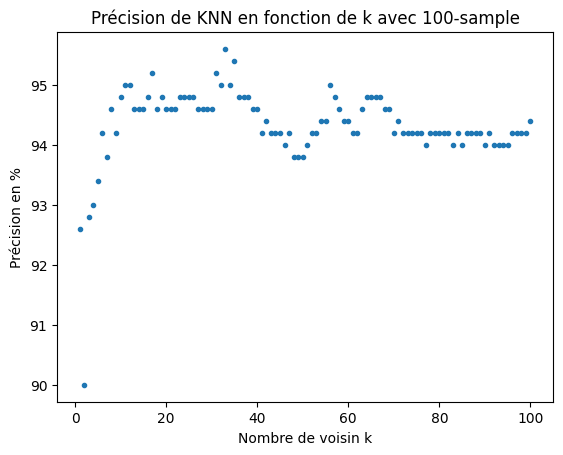

In [124]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(ks, accuracies, '.')
plt.title(f"Précision de KNN en fonction de k avec {number_validation_per_classes}-sample")
plt.xlabel("Nombre de voisin k")
plt.ylabel("Précision en %")
plt.show()

# Simulation N-samples

In [78]:
import numpy as np
import random
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Simulation

In [114]:
max_samples = 30
min_samples = 1
sample_step = 0
number_of_sample_per_step = 5
loop_validation = 0
number_of_tensor = 0

data_validation_tensor = np.zeros((max_samples*len(id2label), 197376))
label_validation_correct = np.zeros((max_samples*len(id2label),))

sample_accuracies = np.zeros((max_samples,))
nb_samples = np.zeros((max_samples,))

for sample_step in range(1, max_samples+1):

  ### Compute data validation

  for cid in classe_id.keys():
    # image_id = classe_id[cid] + random.randint(sample_step - 1, 999)
    image_id = classe_id[cid] + sample_step - 1
    image = data[image_id]

    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
      logits = model(**inputs).last_hidden_state.reshape(1, -1).tolist()[0]
      id = (sample_step-1)*number_of_sample_per_step + int(cid)
      data_validation_tensor[id] = logits
      label_validation_correct[id] = cid

    print("[INFO] processed {}/{}".format(image_id, dataset["train"].num_rows))

  #### Fit Knn

  # train and evaluate a k-NN classifier on tensor of DinoV2
  k_min = 1
  k_max = sample_step

  accuracies = []
  ks = []

  number_of_tensor += number_of_sample_per_step


  for k in range(k_min, k_max+1):

    # print(f"[INFO] evaluating k-NN classifier for k = {k}")
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(data_validation_tensor[:number_of_tensor], label_validation_correct[:number_of_tensor])

    data_test_prediction = knn.predict(data_test_tensor)

    k_accuracy = accuracy_score(label_test_correct, data_test_prediction) * 100

    ks.append(k)
    accuracies.append(k_accuracy)

    # print(classification_report(label_test_correct, knn.predict(data_test), target_names=le.classes_))

  max_accuracy = max(accuracies)
  best_k = ks[accuracies.index(max_accuracy)]

  print(f"[INFO] Best accuracy: {max_accuracy} % pour un k = {best_k}\n")

  sample_accuracies[sample_step-1] = max_accuracy
  nb_samples[sample_step-1] = sample_step

[INFO] processed 0/4999
[INFO] processed 1000/4999
[INFO] processed 2000/4999
[INFO] processed 3000/4999
[INFO] processed 4000/4999
[INFO] Best accuracy: 72.39999999999999 % pour un k = 1

[INFO] processed 1/4999
[INFO] processed 1001/4999
[INFO] processed 2001/4999
[INFO] processed 3001/4999
[INFO] processed 4001/4999
[INFO] Best accuracy: 78.60000000000001 % pour un k = 1

[INFO] processed 2/4999
[INFO] processed 1002/4999
[INFO] processed 2002/4999
[INFO] processed 3002/4999
[INFO] processed 4002/4999
[INFO] Best accuracy: 77.8 % pour un k = 1

[INFO] processed 3/4999
[INFO] processed 1003/4999
[INFO] processed 2003/4999
[INFO] processed 3003/4999
[INFO] processed 4003/4999
[INFO] Best accuracy: 82.19999999999999 % pour un k = 3

[INFO] processed 4/4999
[INFO] processed 1004/4999
[INFO] processed 2004/4999
[INFO] processed 3004/4999
[INFO] processed 4004/4999
[INFO] Best accuracy: 87.0 % pour un k = 4

[INFO] processed 5/4999
[INFO] processed 1005/4999
[INFO] processed 2005/4999
[IN

## Résultats

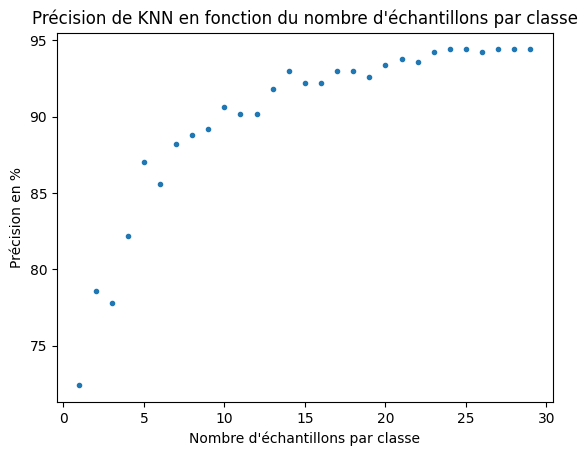

In [116]:
plt.figure()
plt.plot(nb_samples[:-1], sample_accuracies[:-1], '.')
plt.title(f"Précision de KNN en fonction du nombre d'échantillons par classe")
plt.xlabel("Nombre d'échantillons par classe")
plt.ylabel("Précision en %")
plt.show()

# PyTorch pre-trained models

In [ ]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 74.3MB/s]
